## Banana dataset using Bui et al. (2017) model

In [1]:
import numpy as np
import gpflow
import tensorflow as tf
import sys
sys.path.append("../..")

from banana_utils import load_banana_dataset, optimize_streaming_model, plot_banana

In [2]:
plot_probability = True
vmin=0
vmax=1
num_inducing = 25
iterations = 100

## Load data

In [3]:
train_x, train_y, test_x, test_y = load_banana_dataset()

# Make batches
ordering = np.argsort(train_x[:,0])

batch_1 = ordering[:100]
batch_2 = ordering[100:200]
batch_3 = ordering[200:300]
batch_4 = ordering[300:]

batches = [batch_1, batch_2, batch_3, batch_4]

In [4]:
xtest, ytest = np.mgrid[-2.8:2.8:100j, -2.8:2.8:100j]
Xtest = np.vstack((xtest.flatten(), ytest.flatten())).T
Xtest = Xtest.astype(np.float64)

## Initialize Bui et al. (2007) model and optimize

In [5]:
Z = tf.gather(train_x, batches[0])[:num_inducing, :].numpy().copy()

kernel = gpflow.kernels.Matern52()
likelihood = gpflow.likelihoods.Bernoulli()
optimizer = gpflow.optimizers.Scipy()

model = gpflow.models.SVGP(kernel=gpflow.kernels.Matern52(), likelihood=likelihood, 
                           inducing_variable=Z.copy())

In [6]:
new_data = (tf.gather(train_x, batches[0]), tf.gather(train_y, batches[0])[..., None])  
mu, Su, Kaa, Zopt, model = optimize_streaming_model(optimizer=optimizer, model=model, train_data=new_data,
                                              mu=None, Su=None, Kaa=None, Zopt=None,
                                              first_init=True, iterations=iterations)

2023-07-05 12:03:15.598630: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2023-07-05 12:03:18.343892: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-07-05 12:03:18.359478: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


## Plotting

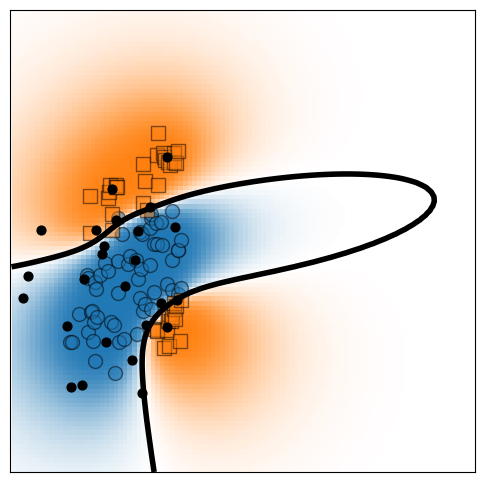

In [7]:
pred_mu, pred_var = model.predict_y(Xtest)

# For plotting purpose
new_data_plot_tmp = (train_x[batches[0]], train_y[batches[0]][..., None])
new_data_plot_0 = new_data_plot_tmp[0] #np.concatenate([new_data_plot[0], new_data_plot_tmp[0]], axis=0)
new_data_plot_1 = new_data_plot_tmp[1] # np.concatenate([new_data_plot[1], new_data_plot_tmp[1]], axis=0)
new_data_plot = (new_data_plot_0, new_data_plot_1)

inducing_variable = model.inducing_variable.Z.numpy()

plot_banana(pred_mu, pred_var, pred_mu, inducing_variable, new_data_plot, xtest, ytest, vmin=vmin, 
            vmax=vmax, plot_inducing=True, plot_probability=plot_probability, plot_colorbar=False)
    

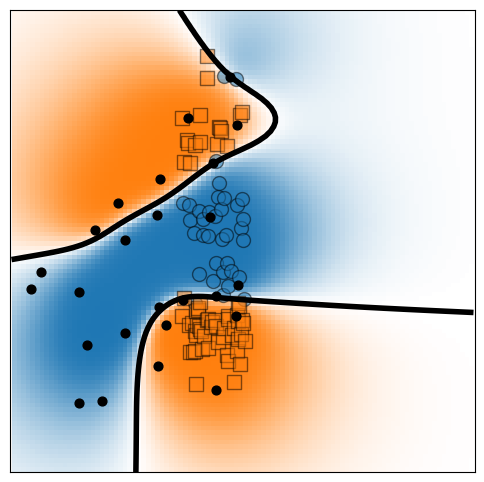

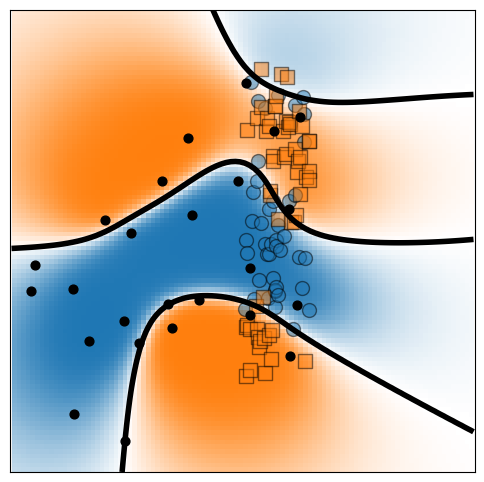

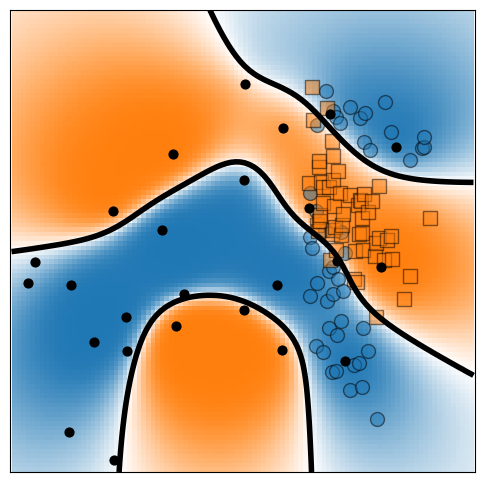

In [8]:
for i in range(1,4):
    new_data = (tf.gather(train_x, batches[i]).numpy(), tf.gather(train_y, batches[i])[..., None].numpy()) 
    mu, Su, Kaa, Zopt, model = optimize_streaming_model(optimizer=optimizer, model=model, train_data=new_data,
                                              mu=mu, Su=Su, Kaa=Kaa, Zopt=Zopt,
                                              first_init=False, iterations=iterations)
    pred_mu, pred_var = model.predict_y(Xtest)
    # For plotting purpose
    new_data_plot_tmp = (train_x[batches[i]], train_y[batches[i]][..., None])
    new_data_plot_0 = new_data_plot_tmp[0] #np.concatenate([new_data_plot[0], new_data_plot_tmp[0]], axis=0)
    new_data_plot_1 = new_data_plot_tmp[1] # np.concatenate([new_data_plot[1], new_data_plot_tmp[1]], axis=0)
    new_data_plot = (new_data_plot_0, new_data_plot_1)

    inducing_variable = model.inducing_variable.Z.numpy()

    plot_banana(pred_mu, pred_var, pred_mu, inducing_variable, new_data_plot, xtest, ytest, vmin=vmin, 
                vmax=vmax, plot_inducing=True, plot_probability=plot_probability, 
                plot_colorbar=False)
